In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import random
import re
import nltk
import contractions
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer
from nltk.stem import WordNetLemmatizer
from nltk.stem import PorterStemmer
from nltk.corpus import wordnet
from nltk.corpus import stopwords
from sklearn.pipeline import Pipeline
from sklearn.decomposition import TruncatedSVD

from sklearn.decomposition import NMF
from sklearn import svm
from sklearn import datasets, metrics
from sklearn.model_selection import KFold
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import GaussianNB
from sklearn.model_selection import GridSearchCV

from sklearn.metrics import plot_confusion_matrix, f1_score, accuracy_score, precision_score, recall_score, confusion_matrix
from sklearn.multiclass import OneVsRestClassifier
from sklearn.multiclass import OneVsOneClassifier


In [2]:
from tempfile import mkdtemp

In [3]:
cachedir = mkdtemp()

In [4]:
fname = 'Project1-Classification.csv'
df = pd.read_csv (fname)

**EDA**

In [3]:
df.head(5)

,full_text,summary,keywords,publish_date,authors,url,leaf_label,root_label
0,"'Pure Hockey, the largest hockey retailer in t...","'Pure Hockey, the largest hockey retailer in t...","['acquire', 'agrees', 'nevada', 'retail', 'hoc...",2022-10-21 17:11:22+00:00,['Ein News'],https://www.einnews.com/pr_news/597148062/pure...,hockey,sports
1,'HKO Hockey Canada Sponsorship 20221006\n\nHoc...,'The tally of Hockey Canada’s sponsorship loss...,"['sexual', 'exclusive', 'settlement', 'million...",NaN,['Barbara Shecter'],https://ca.finance.yahoo.com/news/exclusive-ho...,hockey,sports
2,'Canadian Prime Minister Justin Trudeau said W...,'Canadian Prime Minister Justin Trudeau said W...,"['québec', 'surprise', 'trust', 'sexual', 'org...",2022-10-05 00:00:00,['The Athletic Staff'],https://theathletic.com/3659888/2022/10/05/hoc...,hockey,sports
3,'Hockey Canada paid a crisis communications fi...,'Nicholson says that Hockey Canada did not go ...,"['sexual', 'organization', 'million', 'ceo', '...",2022-11-15 00:00:00,['Dan Robson'],https://theathletic.com/3900630/2022/11/15/hoc...,hockey,sports
4,'The Denver Broncos are looking for a new head...,'The Denver Broncos are looking for a new head...,"['beats', 'force', 'season', 'teams', 'anchora...",NaN,"['Parker Seibold', 'The Gazette', 'Gazette File']",https://gazette.com/multimedia/photo-air-force...,hockey,sports


In [4]:
num_sports_article = len(df.loc[df.root_label == 'sports'])
print("# article with root label == sports =", num_sports_article)
num_climate_article = len(df.loc[df.root_label == 'climate'])
print("# article with root label == climate =", num_climate_article)
print("# total article = ",len(df))
print("Row samples: {}, features: {}, \n".format(df.shape[0], df.shape[1]))

# article with root label == sports = 1750
# article with root label == climate = 1400
# total article =  3150
Row samples: 3150, features: 8, 



In [5]:
FT = df.full_text

In [6]:
FT.head()

0    'Pure Hockey, the largest hockey retailer in t...
1    'HKO Hockey Canada Sponsorship 20221006\n\nHoc...
2    'Canadian Prime Minister Justin Trudeau said W...
3    'Hockey Canada paid a crisis communications fi...
4    'The Denver Broncos are looking for a new head...
Name: full_text, dtype: object

In [7]:
import re
import matplotlib.pyplot as plt
import numpy as np

Text(0, 0.5, 'Frequency of each root label')

<Figure size 432x288 with 0 Axes>

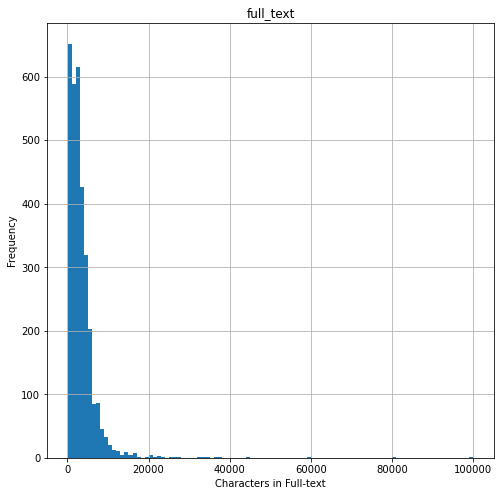

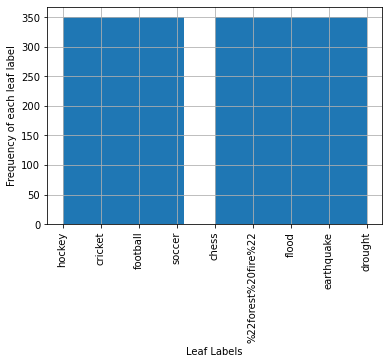

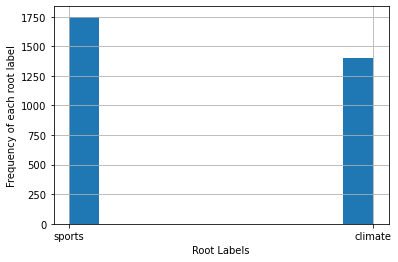

In [8]:
plt.figure()
pd.DataFrame(df['full_text'].apply(lambda x: len(x))).hist(bins=100, figsize= (8, 8))
plt.xlabel("Characters in Full-text")
plt.ylabel("Frequency")


plt.figure()
df['leaf_label'].hist(xrot=90)
plt.xlabel("Leaf Labels")
plt.ylabel("Frequency of each leaf label")


plt.figure()
df['root_label'].hist()
plt.xlabel("Root Labels")
plt.ylabel("Frequency of each root label")

### Q1
a) Row samples: 3150, features: 8 <br>
b) All the graph are plotted in the above cell <br>
c)
 

1.   Graph1 : frequency vs charracter in full text . Some of the character have quite high frequency while some have very low frequency. The distribution in general follows gaussian distribution.
2.   Graph2 : No. of articles vs Leaf labels . we see that sample are evenly distributed into leaf labels with each category having around 350 samples.
3. Graph3 : No. of articles vs Root labels. we see that sample are not evenly distributed in root label and sports category have higher frequency than climate one.



# Binary Classification

In [9]:
import numpy as np
import random
np.random.seed(42)
random.seed(42)

### train test split

In [10]:
from sklearn.model_selection import train_test_split
train, test = train_test_split(df, test_size=0.2)

In [11]:
print("train set size  = ",len(train))
print("test set size  = ",len(test))

train set size  =  2520
test set size  =  630


### Q2 
**Training dataset size**: 2520

**Test dataset size**: 630

### Define Stopwords

In [12]:
# To clean HTML text

"""
- HTML artifacts removal
- Links removal
- quotes removal
- Special characters removal
- Extra spaces removal
- Changing the short forms to full forms using contractions
- Punctuations removal
- Changing all text to lower case
"""

def clean(text):
    text = re.sub(r'^https?:\/\/.*[\r\n]*', '', text, flags=re.MULTILINE)
    texter = re.sub(r"<br />", " ", text)
    texter = re.sub(r'http\S+', '', text)
    texter = re.sub(r"&quot;", "\"",texter)
    texter = re.sub('&#39;', "\"", texter)
    texter = re.sub('\n', " ", texter)
    texter = re.sub(' u '," you ", texter)
    texter = re.sub('`',"", texter)
    texter = re.sub(' +', ' ', texter)
    texter = re.sub(r"(!)\1+", r"!", texter)
    texter = re.sub(r"(\?)\1+", r"?", texter)
    texter = re.sub('&amp;', 'and', texter)
    texter = re.sub('\r', ' ',texter)
    clean = re.compile('<.*?>')
    texter = texter.encode('ascii', 'ignore').decode('ascii')
    texter = re.sub(clean, '', texter)
    texter = texter.strip()
    texter = contractions.fix(texter)
    texter = re.sub('''[!"#$%&'()*+,/;:-<=>?@[\]^_`{|}~-]''', '', texter)
    texter = texter.lower()
    texter = re.sub(' +', ' ', texter)
    if texter == "":
        texter = ""
    return texter

### Feature Extraction

In [13]:
# Function to get POS Tag
def get_pos_tags(nltkTag):
    firstChar = nltkTag[0]
    if firstChar == 'J':
        return wordnet.ADJ
    if firstChar == 'S':
        return wordnet.ADJ_SAT
    if firstChar == 'V':
        return wordnet.VERB
    if firstChar == 'N':
        return wordnet.NOUN
    if firstChar == 'R':
        return wordnet.ADV
    return wordnet.NOUN


In [14]:
# Function to lemmatize each sentence, along with stripping extra spaces, full stops and numbers.
def lemmatize(text):
    tokens = nltk.word_tokenize(text)
    posTags = nltk.pos_tag(tokens)
    tags = [get_pos_tags(w[1]) for w in posTags]
    lemmas = [lemmatizer.lemmatize(tokens[i], tags[i]) for i in range(0, len(tokens))]
    lemmas = ' '.join(lemmas)
    lemmas = re.sub(r'\w*\d\w*', '', lemmas)
    lemmas = re.sub('[.]', '', lemmas)
    lemmas = re.sub(' +', ' ', lemmas).strip()
    return lemmas

In [15]:
#  Function to stem the sentence along with stripping extra spaces, full stops and numbers.
def stemmer(text):
    tokens = nltk.word_tokenize(text)
    stems = [ps.stem(tokens[i]) for i in range(0, len(tokens))]
    stems = ' '.join(stems)
    stems = re.sub(r'\w*\d\w*', '', stems)
    stems = re.sub('[.]', '', stems)
    stems = re.sub(' +', ' ', stems).strip()
    return stems

In [16]:
# Whole preprocessing pipeline with lemmatization
def preprocess(sample):
    sample = clean(sample)
    sample = sample.split('.')
    sample = [lemmatize(sentence) for sentence in sample]
    sample = '.'.join(sample)
    return sample

In [17]:
# Whole preprocessing pipeling with stemming
def preprocessStem(sample):
    sample = clean(sample)
    sample = sample.split('.')
    sample = [stemmer(sentence) for sentence in sample]
    sample = '.'.join(sample)
    return sample

# Preprocessing pipeline with cleaning but without any compression
def preprocessNoCompress(sample):
    sample = clean(sample)
    return sample


# Preprocessing with lemmatization but no cleaning
def preprocessNC(sample):
    sample = sample.split('.')
    sample = [lemmatize(sentence) for sentence in sample]
    sample = '.'.join(sample)
    return sample

# Preprocessing with stemming but no cleaning
def preprocessStemNC(sample):
    sample = sample.split('.')
    sample = [stemmer(sentence) for sentence in sample]
    sample = '.'.join(sample)
    return sample

# Preprocessing without any compression or cleaning
def preprocessNoCompressNC(sample):
    return sample

In [18]:
# Initializations
lemmatizer = WordNetLemmatizer()
ps = PorterStemmer()

stopWords = set(stopwords.words('English'))

### Pipeline for count vector and Tf-idf

In [19]:
# Feature Extraction using CountVectorizer and TF-IDF transformation using Pipeline.
featurePipeline = Pipeline([
    ('count', CountVectorizer(preprocessor=preprocess, stop_words='english', min_df=3)),
    ('tfidf', TfidfTransformer(smooth_idf=True, use_idf=True))
]).fit(train['full_text'])

/Users/diplavsrivastava/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_extraction/text.py:388: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['far', 'make'] not in stop_words.
  warnings.warn('Your stop_words may be inconsistent with '


In [20]:
#  TF-IDF processed train and test matrices.
train_tfidf = featurePipeline.transform(train['full_text'])
test_tfidf = featurePipeline.transform(test['full_text'])

print(" Training data TF-IDF Matrix size: {}".format(train_tfidf.shape))
print("Testing data TF-IDF Matrix size: {}".format(test_tfidf.shape))

 Training data TF-IDF Matrix size: (2520, 14060)
Testing data TF-IDF Matrix size: (630, 14060)


### Q3
a). Pros of Lemmatization:

* Lemmatization tries to incorporate the contextual information of the word. 

* The word's lemma can change depending on the context, which is highly helpful if differentiating in the context of two sentences using the same words.

* Lemmatization can capture the semantic meaning of words in which it is used in a sentence.

Cons of Lemmatization:

* Lemmatization requires a large corpus size to get the lemma of a word as it anlyzes the form and context inwhich it is used. Stemming merely uses the word and attempts to identify its stem by trimming from the front or back of the word in accordance with language-based rules.
* The runtime of lemmatization is slower compared to stemming.

b). On increasing min_df(minimum document frequency) the tf-idf size also reduces as generally not all the word ppresent equally likely in the corpus, so the word which frequency lower than min_df are dropped as a result of which representation vector for each sample also reduces.

c). It is recommended to remove stopword before lemmatization, As lematization might change the stopword and change word might not be present in the list of stopwrods being removed, thus being present in the corpus although it doesn't make any sense. However if we are using word2vec, GLoVE or any Neural Network based lemmatizer which take entire sentence as input to generate vector representation of a word, removal of stopwords can make a difference in the way these embeddings occupy the vector space since stopwords do contribute to some context and semantic meaning to the whole sentence. <br>
It is recommended to remove punctuation in the starting as lemmatizer uses words as input and punctutations don't fall into a word category so they are quite useless. <br>
Numbers can be removed before or after lemmatizing since they are just numerals and dont really have a lemma

d). Training data TF-IDF Matrix size: (2520, 14060) Testing data TF-IDF Matrix size: (630, 14060)

    No. of columns: (k * 10^3) where k ~ 14.1


### Dimensionality Reduction

In [21]:
"""
Functions to get the trained SVD and NMF model
"""

def getSVD(n_comp, data):
    SVD = TruncatedSVD(n_components=n_comp, random_state=42)
    SVD.fit(data)
    return SVD

# NMF Non-negative Matrix Factorization
def getNMF(n_comp, data):
    NMFmodel = NMF(n_components=n_comp, init='random', random_state=42)
    NMFmodel.fit(data)
    return NMFmodel

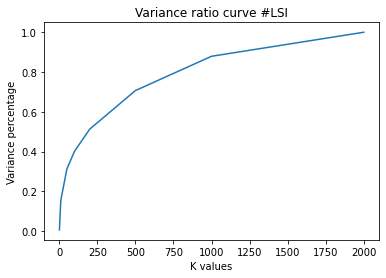

In [22]:
# Plotting variance graph
k_values = [1, 10, 50, 100, 200, 500, 1000, 2000]
variance_ratio = []
reconstructionErrors = []

for i in range(0, len(k_values)):
    SVD = getSVD(k_values[i], train_tfidf)
    variance_ratio.append(SVD.explained_variance_ratio_.sum())
    transformed = SVD.transform(train_tfidf)
    reconstruct = SVD.inverse_transform(transformed)
    reconstructionErrors.append(np.linalg.norm((train_tfidf.toarray() - reconstruct), 'fro') ** 2)
    
plt.plot(k_values, variance_ratio)
plt.xlabel("K values")
plt.ylabel("Variance percentage")
plt.title("Variance ratio curve #LSI")
plt.show()

In [23]:
k = 50
NMFdecomp = getNMF(k, train_tfidf)

In [24]:
# Reconstruction Errors
reconstructedLSIError = reconstructionErrors[2]
reconstructedNMFError = (NMFdecomp.reconstruction_err_)**2

print("Reconstruction residual MSE error for LSI:: {}".format(reconstructedLSIError))
print("Reconstruction residual MSE error for NMF:: {}".format(reconstructedNMFError))

Reconstruction residual MSE error for LSI:: 1676.2833351717513
Reconstruction residual MSE error for NMF:: 1700.1396788381137


### Q4
a). The variance ratio plot for LSI resembles a transitory curve that grows exponentially before saturating.This curve is concave. The concavity of the plot shows that projections along the initial singular vectors, which correspond to the biggest eigenvalues, capture the majority of the variance and that the rest of the data contains more noise and less useful information.

b).
Reconstruction residual MSE error for LSI =  1676.2833351717513 <br>
Reconstruction residual MSE error for NMF = 1700.1396788381137  <br>
Reconstruction residual MSE error for LSI is smaller compared to that from NMF. <br>

NMF tries to identify the key elements that accurately depict the data. As NMF is generally not attempting to reconstruct the original data but rather to identify key features that may be combined to obtain the entire dataset, it is understandable that the reconstruction error for NMF is a bit higher.

For LSI, it works on projecting data to eigen vectors which capture most variance i.e they try to retain most of the data. So LSI's aim to get back the original data. Therefore LSI better in data reconstruction. 

# Classification Algorithm

In [25]:
k_feat = 500
train_labels = np.array((train['root_label'] == 'climate').astype('int'))
test_labels = np.array((test['root_label'] == 'climate').astype('int'))

SVDK500 = getSVD(k_feat, train_tfidf)
trainDataK500 = SVDK500.transform(train_tfidf)
testDataK500 = SVDK500.transform(test_tfidf)

In [26]:
#Hard Linear SVM
HardSVMModel = svm.SVC(kernel='linear', C = 1000)
HardSVMModel.fit(trainDataK500, train_labels)
predictionsHard = HardSVMModel.predict(testDataK500)

# Gamma = 100000
GammaSVMModel = svm.SVC(kernel='linear', C = 100000)
GammaSVMModel.fit(trainDataK500, train_labels)
predictionsGamma = GammaSVMModel.predict(testDataK500)



In [27]:
#Soft Linear SVM
SoftSVMModel = svm.SVC(kernel='linear', C = 0.0001)
SoftSVMModel.fit(trainDataK500, train_labels)
predictionsSoft = SoftSVMModel.predict(testDataK500)

In [66]:
def getScores(y_true, y_pred):
#     y_true = y_true.reshape((-1))
#     y_pred = y_pred.reshape((-1))
#     confusion_matrix = metrics.confusion_matrix(y_true.reshape((-1)), y_pred.reshape((-1)))
#     tn, fp, fn, tp = metrics.confusion_matrix(y_true.reshape((-1)), y_pred.reshape((-1))).ravel()
    accuracy = accuracy_score(y_true, y_pred)
    precision = precision_score(y_true, y_pred, average='weighted', labels=np.unique(y_pred))
    recall = recall_score(y_true, y_pred, average='weighted', labels=np.unique(y_pred))
    f1 = f1_score(y_true, y_pred, average='weighted', labels=np.unique(y_pred))
    
    return {
        'confusion_matrix': confusion_matrix,
        'accuracy': accuracy,
        'precision': precision,
        'recall': recall,
        'f1': f1
    }

svmScores = {
    'HardSMV': {
        'climate': {
            'scores': getScores(test_labels, predictionsHard)
        },
        'sports': {
            'scores': getScores(1 - test_labels, 1 - predictionsHard)
        }
    },
    'HighGammaSVM': {
        'climate': {
            'scores': getScores(test_labels, predictionsGamma)
        },
        'sports': {
            'scores': getScores(1 - test_labels, 1 - predictionsHard)
        }
    },
    'SoftSVM': {
        'climate': {
            'scores': getScores(test_labels, predictionsSoft)
        },
        'sports': {
            'scores': getScores(1 - test_labels, 1 - predictionsHard)
        }
    }
}

In [29]:
# 5-Fold cross validation to find optimal gamma.
def avgKFoldError(clf, train, y):
    kf = KFold(n_splits=5)
    error = 0
    for train_idx, test_idx in kf.split(train):
        x_train, x_test = train[train_idx], train[test_idx]
        y_train, y_test = y[train_idx], y[test_idx]
        
        clf.fit(x_train, y_train)
        predictions = clf.predict(x_test)
        error = error + sum(np.abs(predictions - y_test))
    
    return error / kf.n_splits

In [30]:
# 5-Fold cross validation to find optimal gamma.
def avgKFoldError(clf, train, y):
    kf = KFold(n_splits=5)
    error = 0
    for train_idx, test_idx in kf.split(train):
        x_train, x_test = train[train_idx], train[test_idx]
        y_train, y_test = y[train_idx], y[test_idx]
        
        clf.fit(x_train, y_train)
        predictions = clf.predict(x_test)
        error = error + sum(np.abs(predictions - y_test))
    
    return error / kf.n_splits

In [31]:
gammas = np.linspace(-3,6,10)
bestGamma = -1
minError = np.infty
bestSVM = None
for gamma in gammas:
    SVMk = svm.SVC(kernel='linear', C=(10**gamma))
    err = avgKFoldError(SVMk, trainDataK500, train_labels)
    print(err, SVMk)
    if err <= minError:
        minError = err
        bestGamma = 10**gamma
        bestSVM = SVMk

# Training best SVM
bestSVM.fit(trainDataK500, train_labels)
bestSVMPred = bestSVM.predict(testDataK500)

scores = getScores(test_labels, bestSVMPred)

227.4 SVC(C=0.001, kernel='linear')
227.0 SVC(C=0.01, kernel='linear')
28.2 SVC(C=0.1, kernel='linear')
21.4 SVC(kernel='linear')
27.6 SVC(C=10.0, kernel='linear')
29.6 SVC(C=100.0, kernel='linear')
29.8 SVC(C=1000.0, kernel='linear')
29.8 SVC(C=10000.0, kernel='linear')
29.8 SVC(C=100000.0, kernel='linear')
29.8 SVC(C=1000000.0, kernel='linear')


#### Hard SVM

In [32]:
print("Scores for Hard SVM Model: {}\n".format(HardSVMModel))
print("Accuracy: ", getScores(test_labels, predictionsHard)['accuracy'])
print("Precision: ", getScores(test_labels, predictionsHard)['precision'])
print("Recall Score: ", getScores(test_labels, predictionsHard)['recall'])
print("F1 Score: ", getScores(test_labels, predictionsHard)['f1'])

Scores for Hard SVM Model: SVC(C=1000, kernel='linear')

Accuracy:  0.9714285714285714
Precision:  0.9716951349220243
Recall Score:  0.9714285714285714
F1 Score:  0.9714719491035282


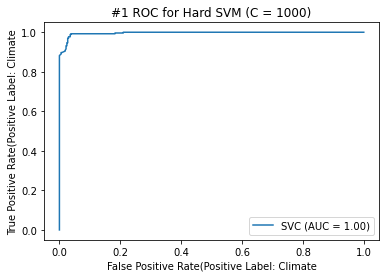

In [33]:
metrics.plot_roc_curve(HardSVMModel,testDataK500, test_labels)
plt.title("#1 ROC for Hard SVM (C = 1000)")
plt.xlabel("False Positive Rate(Positive Label: Climate")
plt.ylabel("True Positive Rate(Positive Label: Climate")
plt.show()

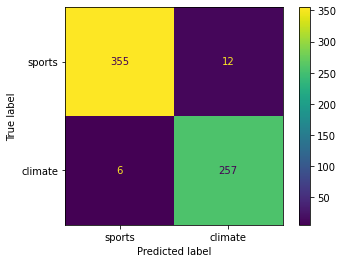

In [34]:
plot_confusion_matrix(HardSVMModel, testDataK500, test_labels, display_labels=['sports', 'climate'])

#### Extreme Hard SVM (γ = 100000)

In [35]:
print("\n\nScores for Extreme Hard Classifier: {}\n".format(GammaSVMModel))
print("Accuracy: ", getScores(test_labels, predictionsGamma)['accuracy'])
print("Precision: ", getScores(test_labels, predictionsGamma)['precision'])
print("Recall Score: ", getScores(test_labels, predictionsGamma)['recall'])
print("F1 Score: ", getScores(test_labels, predictionsGamma)['f1'])



Scores for Extreme Hard Classifier: SVC(C=100000, kernel='linear')

Accuracy:  0.9714285714285714
Precision:  0.9716951349220243
Recall Score:  0.9714285714285714
F1 Score:  0.9714719491035282


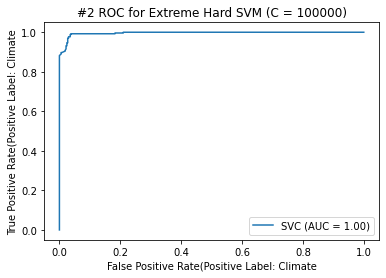

In [36]:
metrics.plot_roc_curve(GammaSVMModel,testDataK500, test_labels)

plt.title("#2 ROC for Extreme Hard SVM (C = 100000)")
plt.xlabel("False Positive Rate(Positive Label: Climate")
plt.ylabel("True Positive Rate(Positive Label: Climate")

plt.show()

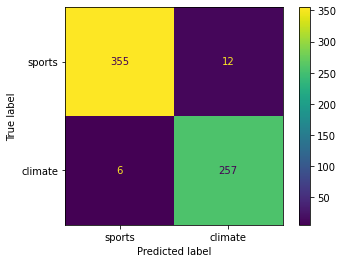

In [37]:
plot_confusion_matrix(GammaSVMModel, testDataK500, test_labels, display_labels=['sports', 'climate'])
plt.show()

#### Soft SVM

In [38]:
print("Scores for Soft SVM Model: {}\n".format(SoftSVMModel))
print("Accuracy: ", getScores(test_labels, predictionsSoft)['accuracy'])
print("Precision: ", getScores(test_labels, predictionsSoft)['precision'])
print("Recall Score: ", getScores(test_labels, predictionsSoft)['recall'])
print("F1 Score: ", getScores(test_labels, predictionsSoft)['f1'])

Scores for Soft SVM Model: SVC(C=0.0001, kernel='linear')

Accuracy:  0.5825396825396826
Precision:  0.5825396825396826
Recall Score:  1.0
F1 Score:  0.7362086258776329


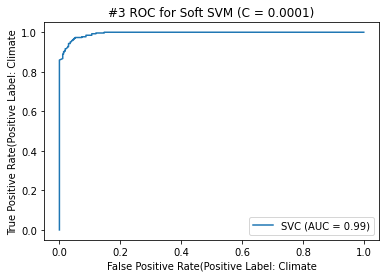

In [39]:
metrics.plot_roc_curve(SoftSVMModel,testDataK500, test_labels)
plt.title("#3 ROC for Soft SVM (C = 0.0001)")
plt.xlabel("False Positive Rate(Positive Label: Climate")
plt.ylabel("True Positive Rate(Positive Label: Climate")
plt.show()


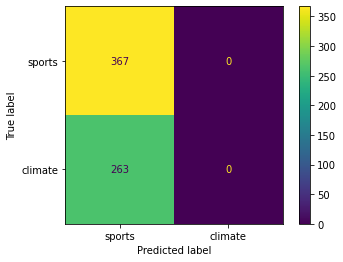

In [40]:
plot_confusion_matrix(SoftSVMModel, testDataK500, test_labels, display_labels=['sports', 'climate'])
plt.show()

#### Best SVM

In [41]:
print("\n\nScores for Best SVM Classifier after 5-Fold cross validation: {}\n".format(bestSVM))
print("Accuracy: ", getScores(test_labels, bestSVMPred)['accuracy'])
print("Precision: ", getScores(test_labels, bestSVMPred)['precision'])
print("Recall Score: ", getScores(test_labels, bestSVMPred)['recall'])
print("F1 Score: ", getScores(test_labels, bestSVMPred)['f1'])



Scores for Best SVM Classifier after 5-Fold cross validation: SVC(kernel='linear')

Accuracy:  0.9682539682539683
Precision:  0.9686977450753418
Recall Score:  0.9682539682539683
F1 Score:  0.9683168569787569


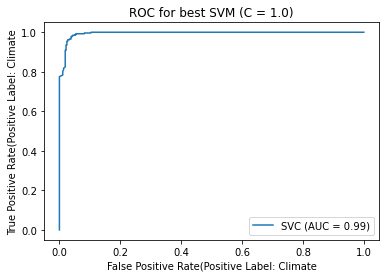

In [42]:
metrics.plot_roc_curve(bestSVM, testDataK500, test_labels)
plt.title("ROC for best SVM (C = {})".format(bestGamma))
plt.xlabel("False Positive Rate(Positive Label: Climate")
plt.ylabel("True Positive Rate(Positive Label: Climate")
plt.show()

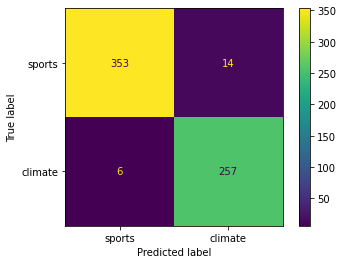

In [43]:
plot_confusion_matrix(bestSVM, testDataK500, test_labels, display_labels=['sports', 'climate'])
plt.show()

## Q5
**a)**. By Analyzing the metric for Linear SVM with γ = 0.0001 and γ = 1000, Linear SVM with γ = 1000 performs better.It has accuracy of around 97.14 % on test data with 12 False Positive and 6 False Negative where as Soft SVM has an accuracy of about 58.25 %.

For extreme hard margin SVM with γ = 100000, we see the results are very close to that of gamma = 1000 which indicates that the data is seprable with quite large margin.

Accuracy metric for all the case is mentioned below 

Scores for Hard SVM Model: SVC(C=1000, kernel='linear')


    Accuracy:  0.9714285714285714
    Precision:  0.9716951349220243
    Recall Score:  0.9714285714285714
    F1 Score:  0.9714719491035282

Scores for Extreme Hard Classifier: SVC(C=100000, kernel='linear')

    Accuracy:  0.9714285714285714
    Precision:  0.9716951349220243
    Recall Score:  0.9714285714285714
    F1 Score:  0.9714719491035282
Scores for Soft SVM Model: SVC(C=0.0001, kernel='linear')

    Accuracy:  0.5825396825396826
    Precision:  0.5825396825396826
    Recall Score:  1.0
    F1 Score:  0.7362086258776329
**b).** The soft SVM with γ = 0.0001 performs very poorly with low precision and accuracy as the penalty for misclassification is quite low. From the the confusion it can be seen that all data points are predicted as sport label.

When compared to all other SVMs, the Soft SVM's ROC curve has the least area under the curve. Although the ROC curve appears to be flawless and has a high AUC therfore we cannot only rely on it. It has a very low operating threshold at which it performs well.

**c).** Using 5-Fold Cross Validation, the best value of gamma = C = 1.0, with average number of missclassifications per fold = 21. Its confusion matrix and ROC curves are plotted above.

Scores for Best SVM Classifier after 5-Fold cross validation: SVC(kernel='linear')

    Accuracy:  0.9682539682539683
    Precision:  0.9686977450753418
    Recall Score:  0.9682539682539683
    F1 Score:  0.9683168569787569

### Logistic Regression

In [44]:
logisticNoReg = LogisticRegression(random_state=42, C=100000, max_iter=5000).fit(trainDataK500, train_labels)
logisticNoRegPred = logisticNoReg.predict(testDataK500)
logisticNoRegScores = getScores(test_labels, logisticNoRegPred)

----------------------------------------------------------------------------------------------------
Metrics for best L1 Logistic classifier without regularization
{'confusion_matrix': <function confusion_matrix at 0x7fa521410820>, 'accuracy': 0.973015873015873, 'precision': 0.9735390292057232, 'recall': 0.973015873015873, 'f1': 0.9730753546235339}


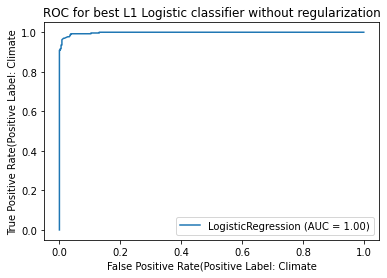

In [45]:
print("-"*100)
print("Metrics for best L1 Logistic classifier without regularization")
print(logisticNoRegScores)

metrics.plot_roc_curve(logisticNoReg, testDataK500, test_labels)
plt.title("ROC for best L1 Logistic classifier without regularization")
plt.xlabel("False Positive Rate(Positive Label: Climate")
plt.ylabel("True Positive Rate(Positive Label: Climate")
plt.show()

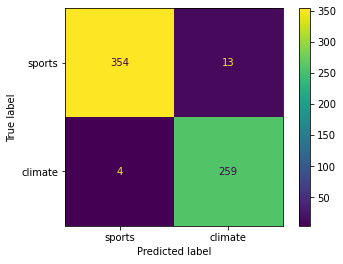

In [46]:
plot_confusion_matrix(logisticNoReg, testDataK500, test_labels, display_labels=['sports', 'climate'])
plt.show()

#### L1 regularization

Avg. no. of misclassification:  227.4 LogisticRegression(C=1e-05, max_iter=5000, penalty='l1', random_state=42,
                   solver='liblinear')
Avg. no. of misclassification:  227.4 LogisticRegression(C=0.0001, max_iter=5000, penalty='l1', random_state=42,
                   solver='liblinear')
Avg. no. of misclassification:  227.4 LogisticRegression(C=0.001, max_iter=5000, penalty='l1', random_state=42,
                   solver='liblinear')
Avg. no. of misclassification:  227.4 LogisticRegression(C=0.01, max_iter=5000, penalty='l1', random_state=42,
                   solver='liblinear')
Avg. no. of misclassification:  37.0 LogisticRegression(C=0.1, max_iter=5000, penalty='l1', random_state=42,
                   solver='liblinear')
Avg. no. of misclassification:  23.4 LogisticRegression(max_iter=5000, penalty='l1', random_state=42,
                   solver='liblinear')
Avg. no. of misclassification:  20.4 LogisticRegression(C=10.0, max_iter=5000, penalty='l1', random_state=4

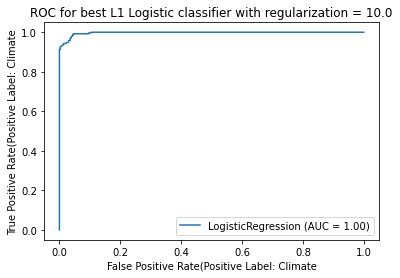

In [47]:
logRegs = np.linspace(-5,5,11)
bestRegL1 = -1
minL1Error = np.infty
bestL1Model = None
for reg in logRegs:
    clfLog = LogisticRegression(penalty='l1', solver='liblinear', random_state=42, C=10**reg, max_iter=5000)
    err = avgKFoldError(clfLog, trainDataK500, train_labels)
    print("Avg. no. of misclassification: ", err, clfLog)
    if err <= minL1Error:
        minL1Error = err
        bestRegL1 = 10**reg
        bestL1Model = clfLog

# Training best L1 Logistic classifier
bestL1Model.fit(trainDataK500, train_labels)
bestL1Pred = bestL1Model.predict(testDataK500)

L1scores = getScores(test_labels, bestL1Pred)
print("-"*100)
print("Metrics for best L1 Logistic classifier with regularization = {}".format(bestRegL1))
print(L1scores)

metrics.plot_roc_curve(bestL1Model, testDataK500, test_labels)
plt.title("ROC for best L1 Logistic classifier with regularization = {}".format(bestRegL1))
plt.xlabel("False Positive Rate(Positive Label: Climate")
plt.ylabel("True Positive Rate(Positive Label: Climate")
plt.show()


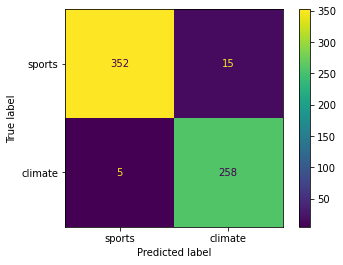

In [48]:
plot_confusion_matrix(bestL1Model, testDataK500, test_labels, display_labels=['sports', 'climate'])
plt.show()

#### L2 regularization 

Avg. no. of misclassification:  227.4 LogisticRegression(C=1e-05, max_iter=5000, random_state=42, solver='liblinear')
Avg. no. of misclassification:  227.4 LogisticRegression(C=0.0001, max_iter=5000, random_state=42, solver='liblinear')
Avg. no. of misclassification:  227.4 LogisticRegression(C=0.001, max_iter=5000, random_state=42, solver='liblinear')
Avg. no. of misclassification:  135.4 LogisticRegression(C=0.01, max_iter=5000, random_state=42, solver='liblinear')
Avg. no. of misclassification:  33.8 LogisticRegression(C=0.1, max_iter=5000, random_state=42, solver='liblinear')
Avg. no. of misclassification:  21.4 LogisticRegression(max_iter=5000, random_state=42, solver='liblinear')
Avg. no. of misclassification:  20.6 LogisticRegression(C=10.0, max_iter=5000, random_state=42, solver='liblinear')
Avg. no. of misclassification:  22.6 LogisticRegression(C=100.0, max_iter=5000, random_state=42, solver='liblinear')
Avg. no. of misclassification:  24.0 LogisticRegression(C=1000.0, max_it

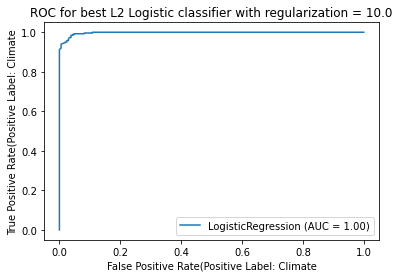

In [67]:
bestRegL2 = -1
minL2Error = np.infty
bestL2Model = None
for reg in logRegs:
    clfLog = LogisticRegression(penalty='l2', random_state=42, C=10**reg, max_iter=5000, solver='liblinear')
    err = avgKFoldError(clfLog, trainDataK500, train_labels)
    print("Avg. no. of misclassification: ", err, clfLog)
    if err <= minL2Error:
        minL2Error = err
        bestRegL2 = 10**reg
        bestL2Model = clfLog

# Training best L2 Logistic classifier
bestL2Model.fit(trainDataK500, train_labels)
bestL2Pred = bestL2Model.predict(testDataK500)

L2scores = getScores(test_labels, bestL2Pred)
print("-"*100)
print("Metrics for best L2 Logistic classifier with regularization = {}".format(bestRegL1))
print(L2scores)

metrics.plot_roc_curve(bestL2Model, testDataK500, test_labels)
plt.title("ROC for best L2 Logistic classifier with regularization = {}".format(bestRegL2))
plt.xlabel("False Positive Rate(Positive Label: Climate")
plt.ylabel("True Positive Rate(Positive Label: Climate")
plt.show()

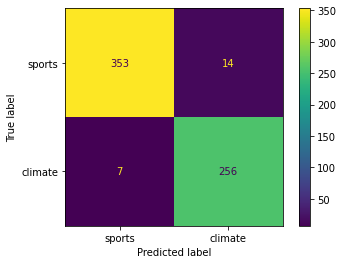

In [71]:
plot_confusion_matrix(bestL2Model, testDataK500, test_labels, display_labels=['sports', 'climate'])
plt.show()

### Q6

**a).** The ROC curve and condusion matrix for Logistic Regression without regularization are shown above. The scores for the same on testing set are as follows:

    Accuracy: 0.973015873015873 
    Precision: 0.9735390292057232 
    Recall Score: 0.97301587301587
    F1 Score: 0.9730753546235339
**b).** The optimal L1 regularization strength which is obtained after performing 5-fold cross validation on dimension reduced by SVD data is: C = 10.0 which is equal to 0.1 regularization strength. Solver = 'liblinear'

    Accuracy: 0.9682539682539683
    Precision: 0.968903800836574
    Recall Score: 0.9682539682539683
    F1 Score: 0.9683308660590758
The optimal L2 regularization strength which is obtained after performing 5-fold cross validation on dimension reduced by SVD data is: C = 10.0 which is equal to 0.1 regularization strength. Solver = 'liblinear'

    Accuracy: 0.9666666666666667
    Precision: 0.9670267489711935
    Recall Score: 0.9666666666666667
    F1 Score: 0.9667250766254357
**c).** 
 Below are the avg no. of missclassification for L! regularization at different parameter --
 
    Avg. no. of misclassification:  227.4         C=1e-05
    Avg. no. of misclassification:  227.4         C=0.0001
    Avg. no. of misclassification:  227.4         C=0.001
    Avg. no. of misclassification:  135.4         C=0.01
    Avg. no. of misclassification:  37.0          C=0.1
    Avg. no. of misclassification:  21.4          C=1.0
    Avg. no. of misclassification:  20.6          C=10.0
    Avg. no. of misclassification:  22.6          C=100.0
    Avg. no. of misclassification:  24.4          C=1000.0
    Avg. no. of misclassification:  30.8          C=10000.0
    Avg. no. of misclassification:  36.0          C=100000.0

For L2 regularizer 

    Avg. no. of misclassification:  227.4         C=1e-05
    Avg. no. of misclassification:  227.4         C=0.0001
    Avg. no. of misclassification:  227.4         C=0.001
    Avg. no. of misclassification:  227.4         C=0.01
    Avg. no. of misclassification:  33.8          C=0.1
    Avg. no. of misclassification:  23.4          C=1.0
    Avg. no. of misclassification:  20.4          C=10.0
    Avg. no. of misclassification:  22.6          C=100.0
    Avg. no. of misclassification:  24.0          C=1000.0
    Avg. no. of misclassification:  25.8          C=10000.0
    Avg. no. of misclassification:  26.8          C=100000.0

From the above account we can see that the test error first decreases with the increase in regularization parameter from 0.0001 till 10 where it achieves its minima and then the test error increases with the increase in regularization parameter.

Effect of regularization on the learned coefficients <br>
-->The effect of features is significantly diminished as the regularization value is increased, and as the regularization parameter is increased further, the model becomes overly relaxed and begins to perform worse due to high underfitting as features only represent a straight line with zero slope.

-->Since L2 penalizes errors more, it is used when the data is clean and there aren't many outliers. L2 is also used when all features should be taken into account because L2 regularization doesn't aid in feature selection.

-->When one is unsure about the important feature we can use L1 regularizer as in case of L1 regularizer Unimportant feature weights are assigned to 0. L1 regularizer can also be used when there are alot of outlier.

    
**d).**
SVM and logistic regression are pretty similar to one another in that they both use a linear decision boundary to categorize the data. SVM employs a geometrical/deterministic method, whereas logistic regression uses a probability-based technique. While SVM seeks to identify a decision boundary or separating hyperplane that optimizes the distance between the dividing hyperplace, logistic regression seeks to identify the probability in favor of a class. Because SVM incorporates the concept of margins, their performances vary. When the data is completely linearly separable the results are very much comparable for both but when its' not the case, the gamma parameter in SVM's decides the difference in results between Logistic and SVM.

Additionally, SVMs perform better when the data contains more features than the training examples since they used the Kernelization method to escape the dimensionality curse, whereas Logistic Regression does not. Additionally, SVM can fit non-linear decision bounds while LR cannot.

With the above data in hand, Logistic Regression seems to perform better having 97.3 % accuracy compared to that of 97.1% of SVM's.




### Naive Bayes Model

In [49]:
# Gaussian Naive Bayes Model
GaussianNBModel = GaussianNB()
GaussianNBModel.fit(trainDataK500, train_labels)
gaussianNBPred = GaussianNBModel.predict(testDataK500)
gaussianNBScores = getScores(test_labels, gaussianNBPred)

In [50]:
print("Scores for Gaussian Naive Bayes Classifier : {}\n".format(GaussianNBModel))
print("Accuracy: ", gaussianNBScores['accuracy'])
print("Precision: ", gaussianNBScores['precision'])
print("Recall Score: ", gaussianNBScores['recall'])
print("F1 Score: ", gaussianNBScores['f1'])

Scores for Gaussian Naive Bayes Classifier : GaussianNB()

Accuracy:  0.9365079365079365
Precision:  0.9393953482740668
Recall Score:  0.9365079365079365
F1 Score:  0.9368014955237132


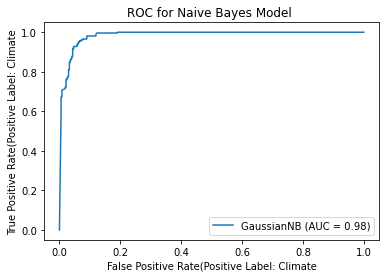

In [51]:
metrics.plot_roc_curve(GaussianNBModel, testDataK500, test_labels)
plt.title("ROC for Naive Bayes Model ")
plt.xlabel("False Positive Rate(Positive Label: Climate")
plt.ylabel("True Positive Rate(Positive Label: Climate")
plt.show()

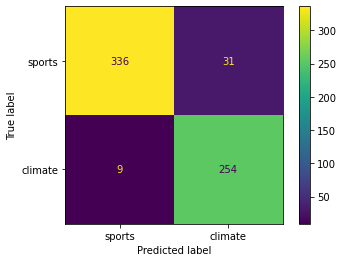

In [52]:
plot_confusion_matrix(GaussianNBModel, testDataK500, test_labels, display_labels=['sports', 'climate'])
plt.show()

### Q7)

**a).** Scores for Gaussian Naive Bayes Classifier : GaussianNB() <br>
    Accuracy:  0.9365079365079365 <br>
    Precision:  0.9393953482740668 <br>
    Recall Score:  0.9365079365079365 <br>
    F1 Score:  0.9368014955237132 <br>

### Grid Search of Parameter

In [90]:
ftExtLemma3 = CountVectorizer(preprocessor=preprocess, stop_words='english', min_df=3)
ftExtStem3 = CountVectorizer(preprocessor=preprocessStem, stop_words='english', min_df=3)
ftExtNone3 = CountVectorizer(preprocessor=preprocessNoCompress, stop_words='english', min_df=3)
ftExtLemma5 = CountVectorizer(preprocessor=preprocess, stop_words='english', min_df=5)
ftExtStem5 = CountVectorizer(preprocessor=preprocessStem, stop_words='english', min_df=5)
ftExtNone5 = CountVectorizer(preprocessor=preprocessNoCompress, stop_words='english', min_df=5)

ftExtLemma3NC = CountVectorizer(preprocessor=preprocessNC, stop_words='english', min_df=3)
ftExtStem3NC = CountVectorizer(preprocessor=preprocessStemNC, stop_words='english', min_df=3)
ftExtNone3NC = CountVectorizer(preprocessor=preprocessNoCompressNC, stop_words='english', min_df=3)
ftExtLemma5NC = CountVectorizer(preprocessor=preprocessNC, stop_words='english', min_df=5)
ftExtStem5NC = CountVectorizer(preprocessor=preprocessStemNC, stop_words='english', min_df=5)
ftExtNone5NC = CountVectorizer(preprocessor=preprocessNoCompressNC, stop_words='english', min_df=5)

clfGaussian = GaussianNB()
clfLogisticL1 = LogisticRegression(C=10.0, max_iter=5000, penalty='l1', random_state=42, solver='liblinear')
clfLogisticL2 = LogisticRegression(C=10.0, max_iter=5000, penalty='l2', random_state=42, solver='liblinear')
clfSVM = svm.SVC(C=1.0, kernel='linear')

LSIred5 = TruncatedSVD(n_components=5, random_state=42)
LSIred50 = TruncatedSVD(n_components=50, random_state=42)
LSIred80 = TruncatedSVD(n_components=80, random_state=42)
NMFred5 = NMF(n_components=5, init='random', random_state=42)
NMFred50 = NMF(n_components=50, init='random', random_state=42)
NMFred80 = NMF(n_components=80, init='random', random_state=42)


gridSearchPipe = Pipeline([
    ('count', ftExtLemma3),
    ('tfidf', TfidfTransformer(smooth_idf=True, use_idf=True)),
    ('dim_reduce', LSIred5),
    ('clf', clfSVM)
])

parameters = [
    {
        'count': [ftExtLemma3, ftExtStem3, ftExtNone3, ftExtLemma5, ftExtStem5, ftExtNone5, ftExtLemma3NC, ftExtStem3NC, ftExtNone3NC, ftExtLemma5NC, ftExtStem5NC, ftExtNone5NC],
        'dim_reduce': [LSIred5, LSIred50, LSIred80, NMFred5, NMFred50,NMFred80],
        'clf': [clfSVM, clfLogisticL1, clfLogisticL2, clfGaussian],
    }
]



In [92]:
grid = GridSearchCV(gridSearchPipe, cv=5, param_grid = parameters, scoring='accuracy')
grid.fit(train['full_text'], train_labels)
resultsGridSearch = pd.DataFrame(grid.cv_results_)

/Users/diplavsrivastava/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_extraction/text.py:388: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['abov', 'afterward', 'alon', 'alreadi', 'alway', 'ani', 'anoth', 'anyon', 'anyth', 'anywher', 'becam', 'becaus', 'becom', 'befor', 'besid', 'cri', 'describ', 'dure', 'els', 'elsewher', 'empti', 'everi', 'everyon', 'everyth', 'everywher', 'fifti', 'formerli', 'forti', 'ha', 'henc', 'hereaft', 'herebi', 'hi', 'howev', 'hundr', 'inde', 'latterli', 'mani', 'meanwhil', 'moreov', 'mostli', 'nobodi', 'noon', 'noth', 'nowher', 'onc', 'onli', 'otherwis', 'ourselv', 'perhap', 'pleas', 'seriou', 'sever', 'sinc', 'sincer', 'sixti', 'someon', 'someth', 'sometim', 'somewher', 'themselv', 'thenc', 'thereaft', 'therebi', 'therefor', 'thi', 'thu', 'togeth', 'twelv', 'twenti', 'veri', 'wa', 'whatev', 'whenc', 'whenev', 'wherea', 'whereaft', 'wherebi', 'wherev', 'whi', 'yourselv'] not

/Users/diplavsrivastava/opt/anaconda3/lib/python3.8/site-packages/sklearn/decomposition/_nmf.py:1090: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  warnings.warn("Maximum number of iterations %d reached. Increase it to"
/Users/diplavsrivastava/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_extraction/text.py:388: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['abov', 'afterward', 'alon', 'alreadi', 'alway', 'ani', 'anoth', 'anyon', 'anyth', 'anywher', 'becam', 'becaus', 'becom', 'befor', 'besid', 'cri', 'describ', 'dure', 'els', 'elsewher', 'empti', 'everi', 'everyon', 'everyth', 'everywher', 'fifti', 'formerli', 'forti', 'ha', 'henc', 'hereaft', 'herebi', 'hi', 'howev', 'hundr', 'inde', 'latterli', 'mani', 'meanwhil', 'moreov', 'mostli', 'nobodi', 'noon', 'noth', 'nowher', 'onc', 'onli', 'otherwis', 'ourselv', 'perhap', 'pleas', 'seriou', 'sever', 'si

/Users/diplavsrivastava/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_extraction/text.py:388: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['abov', 'afterward', 'alon', 'alreadi', 'alway', 'ani', 'anoth', 'anyon', 'anyth', 'anywher', 'becam', 'becaus', 'becom', 'befor', 'besid', 'cri', 'describ', 'dure', 'els', 'elsewher', 'empti', 'everi', 'everyon', 'everyth', 'everywher', 'fifti', 'formerli', 'forti', 'ha', 'henc', 'hereaft', 'herebi', 'hi', 'howev', 'hundr', 'inde', 'latterli', 'mani', 'meanwhil', 'moreov', 'mostli', 'nobodi', 'noon', 'noth', 'nowher', 'onc', 'onli', 'otherwis', 'ourselv', 'perhap', 'pleas', 'seriou', 'sever', 'sinc', 'sincer', 'sixti', 'someon', 'someth', 'sometim', 'somewher', 'themselv', 'thenc', 'thereaft', 'therebi', 'therefor', 'thi', 'thu', 'togeth', 'twelv', 'twenti', 'veri', 'wa', 'whatev', 'whenc', 'whenev', 'wherea', 'whereaft', 'wherebi', 'wherev', 'whi', 'yourselv'] not

/Users/diplavsrivastava/opt/anaconda3/lib/python3.8/site-packages/sklearn/decomposition/_nmf.py:1090: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  warnings.warn("Maximum number of iterations %d reached. Increase it to"
/Users/diplavsrivastava/opt/anaconda3/lib/python3.8/site-packages/sklearn/decomposition/_nmf.py:1090: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  warnings.warn("Maximum number of iterations %d reached. Increase it to"
/Users/diplavsrivastava/opt/anaconda3/lib/python3.8/site-packages/sklearn/decomposition/_nmf.py:1090: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  warnings.warn("Maximum number of iterations %d reached. Increase it to"
/Users/diplavsrivastava/opt/anaconda3/lib/python3.8/site-packages/sklearn/decomposition/_nmf.py:1090: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to

/Users/diplavsrivastava/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_extraction/text.py:388: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['abov', 'afterward', 'alon', 'alreadi', 'alway', 'ani', 'anoth', 'anyon', 'anyth', 'anywher', 'becam', 'becaus', 'becom', 'befor', 'besid', 'cri', 'describ', 'dure', 'els', 'elsewher', 'empti', 'everi', 'everyon', 'everyth', 'everywher', 'fifti', 'formerli', 'forti', 'ha', 'henc', 'hereaft', 'herebi', 'hi', 'howev', 'hundr', 'inde', 'latterli', 'mani', 'meanwhil', 'moreov', 'mostli', 'nobodi', 'noon', 'noth', 'nowher', 'onc', 'onli', 'otherwis', 'ourselv', 'perhap', 'pleas', 'seriou', 'sever', 'sinc', 'sincer', 'sixti', 'someon', 'someth', 'sometim', 'somewher', 'themselv', 'thenc', 'thereaft', 'therebi', 'therefor', 'thi', 'thu', 'togeth', 'twelv', 'twenti', 'veri', 'wa', 'whatev', 'whenc', 'whenev', 'wherea', 'whereaft', 'wherebi', 'wherev', 'whi', 'yourselv'] not

/Users/diplavsrivastava/opt/anaconda3/lib/python3.8/site-packages/sklearn/decomposition/_nmf.py:1090: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  warnings.warn("Maximum number of iterations %d reached. Increase it to"


In [93]:
resultsGridSearch.sort_values(by=['mean_test_score'], ascending=False).head(5)

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_clf,param_count,param_dim_reduce,params,split0_test_score,split1_test_score,mean_test_score,std_test_score,rank_test_score
12,1.307325,0.016238,1.176674,0.105106,"LogisticRegression(C=10.0, max_iter=5000, pena...","CountVectorizer(min_df=5,\n pre...","TruncatedSVD(n_components=80, random_state=42)","{'clf': LogisticRegression(C=10.0, max_iter=50...",0.964286,0.957143,0.960714,0.003571,1
10,1.741511,0.009828,1.271615,0.091427,"LogisticRegression(C=10.0, max_iter=5000, pena...","CountVectorizer(min_df=3,\n pre...","TruncatedSVD(n_components=80, random_state=42)","{'clf': LogisticRegression(C=10.0, max_iter=50...",0.960317,0.958730,0.959524,0.000794,2
18,1.761026,0.164394,1.321624,0.047085,"LogisticRegression(C=10.0, max_iter=5000, rand...","CountVectorizer(min_df=3,\n pre...","TruncatedSVD(n_components=80, random_state=42)","{'clf': LogisticRegression(C=10.0, max_iter=50...",0.958730,0.955556,0.957143,0.001587,3
25,38.764913,1.891616,18.877065,0.823975,GaussianNB(),"CountVectorizer(min_df=3,\n pre...","NMF(init='random', n_components=80, random_sta...","{'clf': GaussianNB(), 'count': CountVectorizer...",0.962698,0.950000,0.956349,0.006349,4
16,18.102715,0.498709,17.501812,0.501326,"LogisticRegression(C=10.0, max_iter=5000, rand...","CountVectorizer(min_df=3,\n pre...","TruncatedSVD(n_components=80, random_state=42)","{'clf': LogisticRegression(C=10.0, max_iter=50...",0.957143,0.954762,0.955952,0.001190,5


#### Evaluation for Best Model

Scores for Best Classifier 1 : LogisticRegression(C=10.0, max_iter=5000, penalty='l1', random_state=42,
                   solver='liblinear')

Accuracy:  0.9682539682539683
Precision:  0.968903800836574
Recall Score:  0.9682539682539683
F1 Score:  0.9683308660590758


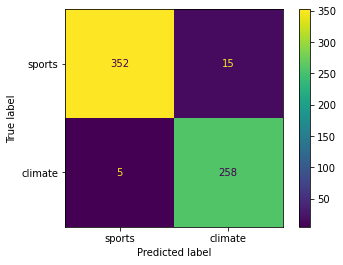

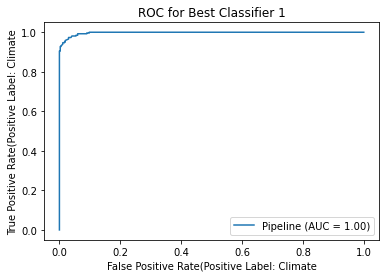

In [94]:
pipe1 = Pipeline([
    ('count', ftExtNone5),
    ('tfidf', TfidfTransformer(smooth_idf=True, use_idf=True)),
    ('dim_reduce', LSIred80),
    ('clf', clfLogisticL1)
]).fit(train['full_text'], train_labels)

pipe1pred = pipe1.predict(test['full_text'])
pipe1Scores = getScores(test_labels, pipe1pred)

print("Scores for Best Classifier 1 : {}\n".format(pipe1['clf']))
print("Accuracy: ", pipe1Scores['accuracy'])
print("Precision: ", pipe1Scores['precision'])
print("Recall Score: ", pipe1Scores['recall'])
print("F1 Score: ", pipe1Scores['f1'])

plot_confusion_matrix(pipe1, test['full_text'], test_labels, display_labels=['sports', 'climate'])
plt.show()

metrics.plot_roc_curve(pipe1, test['full_text'], test_labels)
plt.title("ROC for Best Classifier 1")
plt.xlabel("False Positive Rate(Positive Label: Climate")
plt.ylabel("True Positive Rate(Positive Label: Climate")
plt.show()

Scores for Best Classifier 2 : LogisticRegression(C=10.0, max_iter=5000, penalty='l1', random_state=42,
                   solver='liblinear')

Accuracy:  0.9666666666666667
Precision:  0.9672150564136269
Recall Score:  0.9666666666666667
F1 Score:  0.9667401439467183


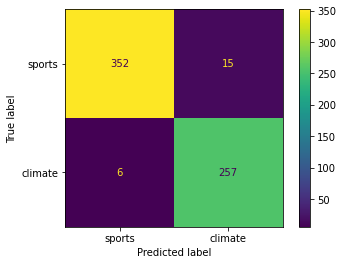

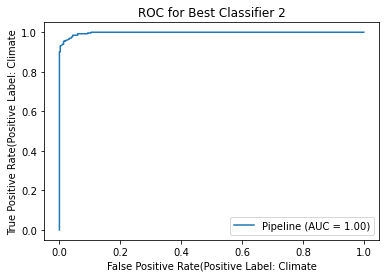

In [95]:
pipe2 = Pipeline([
    ('count', ftExtNone3),
    ('tfidf', TfidfTransformer(smooth_idf=True, use_idf=True)),
    ('dim_reduce', LSIred80),
    ('clf', clfLogisticL1)
]).fit(train['full_text'], train_labels)

pipe2pred = pipe2.predict(test['full_text'])
pipe2Scores = getScores(test_labels, pipe2pred)


print("Scores for Best Classifier 2 : {}\n".format(pipe2['clf']))
print("Accuracy: ", pipe2Scores['accuracy'])
print("Precision: ", pipe2Scores['precision'])
print("Recall Score: ", pipe2Scores['recall'])
print("F1 Score: ", pipe2Scores['f1'])

plot_confusion_matrix(pipe2, test['full_text'], test_labels, display_labels=['sports', 'climate'])
plt.show()

metrics.plot_roc_curve(pipe2, test['full_text'], test_labels)
plt.title("ROC for Best Classifier 2")
plt.xlabel("False Positive Rate(Positive Label: Climate")
plt.ylabel("True Positive Rate(Positive Label: Climate")
plt.show()

/Users/diplavsrivastava/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_extraction/text.py:388: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['abov', 'afterward', 'alon', 'alreadi', 'alway', 'ani', 'anoth', 'anyon', 'anyth', 'anywher', 'becam', 'becaus', 'becom', 'befor', 'besid', 'cri', 'describ', 'dure', 'els', 'elsewher', 'empti', 'everi', 'everyon', 'everyth', 'everywher', 'fifti', 'formerli', 'forti', 'ha', 'henc', 'hereaft', 'herebi', 'hi', 'howev', 'hundr', 'inde', 'latterli', 'mani', 'meanwhil', 'moreov', 'mostli', 'nobodi', 'noon', 'noth', 'nowher', 'onc', 'onli', 'otherwis', 'ourselv', 'perhap', 'pleas', 'seriou', 'sever', 'sinc', 'sincer', 'sixti', 'someon', 'someth', 'sometim', 'somewher', 'themselv', 'thenc', 'thereaft', 'therebi', 'therefor', 'thi', 'thu', 'togeth', 'twelv', 'twenti', 'veri', 'wa', 'whatev', 'whenc', 'whenev', 'wherea', 'whereaft', 'wherebi', 'wherev', 'whi', 'yourselv'] not

Scores for Best Classifier 3 : LogisticRegression(C=10.0, max_iter=5000, penalty='l1', random_state=42,
                   solver='liblinear')

Accuracy:  0.9650793650793651
Precision:  0.9657428783479203
Recall Score:  0.9650793650793651
F1 Score:  0.9651639526649833


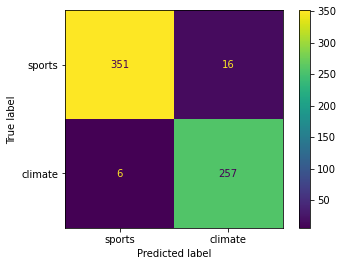

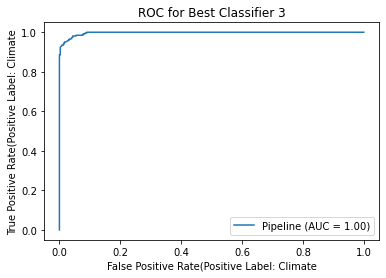

In [96]:
pipe3 = Pipeline([
    ('count', ftExtStem3NC),
    ('tfidf', TfidfTransformer(smooth_idf=True, use_idf=True)),
    ('dim_reduce', LSIred80),
    ('clf', clfLogisticL1)
]).fit(train['full_text'], train_labels)

pipe3pred = pipe3.predict(test['full_text'])
pipe3Scores = getScores(test_labels, pipe3pred)


print("Scores for Best Classifier 3 : {}\n".format(pipe3['clf']))
print("Accuracy: ", pipe3Scores['accuracy'])
print("Precision: ", pipe3Scores['precision'])
print("Recall Score: ", pipe3Scores['recall'])
print("F1 Score: ", pipe3Scores['f1'])

plot_confusion_matrix(pipe3, test['full_text'], test_labels, display_labels=['sports', 'climate'])
plt.show()

metrics.plot_roc_curve(pipe3, test['full_text'], test_labels)
plt.title("ROC for Best Classifier 3")
plt.xlabel("False Positive Rate(Positive Label: Climate")
plt.ylabel("True Positive Rate(Positive Label: Climate")
plt.show()

/Users/diplavsrivastava/opt/anaconda3/lib/python3.8/site-packages/sklearn/decomposition/_nmf.py:1090: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  warnings.warn("Maximum number of iterations %d reached. Increase it to"


Scores for Best Classifier 4 : GaussianNB()

Accuracy:  0.9619047619047619
Precision:  0.9625819558592668
Recall Score:  0.9619047619047619
F1 Score:  0.961997039270891


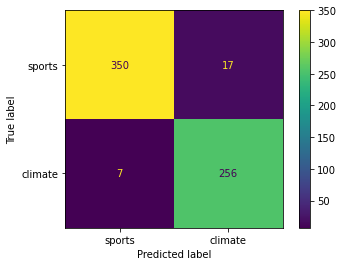

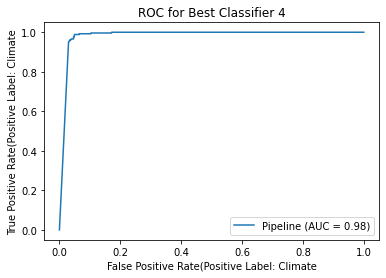

In [98]:
pipe4 = Pipeline([
    ('count', ftExtStem3NC),
    ('tfidf', TfidfTransformer(smooth_idf=True, use_idf=True)),
    ('dim_reduce', NMFred80),
    ('clf', clfGaussian)
]).fit(train['full_text'], train_labels)

pipe4pred = pipe4.predict(test['full_text'])
pipe4Scores = getScores(test_labels, pipe4pred)



print("Scores for Best Classifier 4 : {}\n".format(pipe4['clf']))
print("Accuracy: ", pipe4Scores['accuracy'])
print("Precision: ", pipe4Scores['precision'])
print("Recall Score: ", pipe4Scores['recall'])
print("F1 Score: ", pipe4Scores['f1'])

plot_confusion_matrix(pipe4, test['full_text'], test_labels, display_labels=['sports', 'climate'])
plt.show()

metrics.plot_roc_curve(pipe4, test['full_text'], test_labels)
plt.title("ROC for Best Classifier 4")
plt.xlabel("False Positive Rate(Positive Label: Climate")
plt.ylabel("True Positive Rate(Positive Label: Climate")
plt.show()

/Users/diplavsrivastava/opt/anaconda3/lib/python3.8/site-packages/sklearn/feature_extraction/text.py:388: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['far', 'make'] not in stop_words.
  warnings.warn('Your stop_words may be inconsistent with '


Scores for Best Classifier 5 : LogisticRegression(C=10.0, max_iter=5000, penalty='l1', random_state=42,
                   solver='liblinear')

Accuracy:  0.9650793650793651
Precision:  0.9657428783479203
Recall Score:  0.9650793650793651
F1 Score:  0.9651639526649833


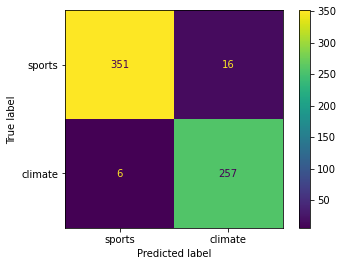

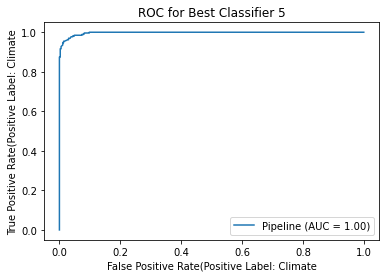

In [100]:
pipe5 = Pipeline([
    ('count', ftExtLemma3),
    ('tfidf', TfidfTransformer(smooth_idf=True, use_idf=True)),
    ('dim_reduce', LSIred80),
    ('clf', clfLogisticL1)
]).fit(train['full_text'], train_labels)

pipe5pred = pipe5.predict(test['full_text'])
pipe5Scores = getScores(test_labels, pipe5pred)


print("Scores for Best Classifier 5 : {}\n".format(pipe5['clf']))
print("Accuracy: ", pipe5Scores['accuracy'])
print("Precision: ", pipe5Scores['precision'])
print("Recall Score: ", pipe5Scores['recall'])
print("F1 Score: ", pipe5Scores['f1'])

plot_confusion_matrix(pipe5, test['full_text'], test_labels, display_labels=['sports', 'climate'])
plt.show()

metrics.plot_roc_curve(pipe5, test['full_text'], test_labels)
plt.title("ROC for Best Classifier 5")
plt.xlabel("False Positive Rate(Positive Label: Climate")
plt.ylabel("True Positive Rate(Positive Label: Climate")
plt.show()

### Question 8
5 best combinations are 

1). Ceaning/ Not Cleaning: No Cleaning
    
    min_df = 5
    Compression: Nothing
    Stop words: True
    Dim Reduction: LSI with 80 components
    Classifier: LogisticRegression(C=10.0, max_iter=5000, penalty='l1', random_state=42, solver='liblinear')

    Accuracy:  0.9682539682539683
    Precision:  0.968903800836574
    Recall Score:  0.9682539682539683
    F1 Score:  0.9683308660590758

2). Ceaning/ Not Cleaning: No Cleaning
    
    min_df = 3
    Compression: Stemming
    Stop words: True
    Dim Reduction: LSI with 80 components
    Classifier: LogisticRegression(C=10.0, max_iter=5000, penalty='l1', random_state=42, solver='liblinear')

    Accuracy:  0.9666666666666667
    Precision:  0.9672150564136269
    Recall Score:  0.9666666666666667
    F1 Score:  0.9667401439467183

3). Ceaning/ Not Cleaning: Cleaning
    
    min_df :  3
    Compression: Nothing
    Stop words: True
    Dim Reduction: LSI with 80 components
    Classifier: GaussianNB()

    Accuracy:  0.9650793650793651
    Precision:  0.9657428783479203
    Recall Score:  0.9650793650793651
    F1 Score:  0.9651639526649833
    
4). Ceaning/ Not Cleaning: Cleaning
    
    min_df = 3
    Compression: Nothing
    Stop words: True
    Dim Reduction: LSI with 80 components
    Classifier: LogisticRegression(C=10.0, max_iter=5000, penalty='l1', random_state=42, solver='liblinear')

    Accuracy:  0.9650793650793651
    Precision:  0.9657428783479203
    Recall Score:  0.9650793650793651
    F1 Score:  0.9651639526649833

5). Ceaning/ Not Cleaning: Cleaning
    
    min_df = 3
    Compression: Stemming
    Stop words: True
    Dim Reduction: NMF with 50 components
    Classifier: LogisticRegression(C=10.0, max_iter=5000, penalty='l1', random_state=42, solver='liblinear')

    Accuracy:  0.9619047619047619
    Precision:  0.9625819558592668
    Recall Score:  0.9619047619047619
    F1 Score:  0.961997039270891

### Multiclass Classification 

In [53]:
train_leaf_labels = train['leaf_label']
test_leaf_labels = test['leaf_label']

labels = ['chess', 'cricket', 'hockey', 'soccer', 'football', 'forestfire', 'flood','earthquake', 'drought']

train_leaf_labels = train_leaf_labels.replace(to_replace=['chess', 'cricket','hockey', 'soccer', 'football', '%22forest%20fire%22', 'flood', 'earthquake', 'drought'], value=[0, 1, 2, 3, 4, 5, 6, 7, 8], inplace=False)
test_leaf_labels =  test_leaf_labels.replace(to_replace =['chess', 'cricket','hockey', 'soccer', 'football', '%22forest%20fire%22', 'flood', 'earthquake', 'drought'], value=[0, 1, 2, 3, 4, 5, 6, 7, 8], inplace=False)

#### Naive Bayes for Multiclass Classification

Scores for Gaussian Naive Bayes Classifier
accuracy: 0.5603174603174603
recall: 0.5598705675166241
precision: 0.618678457588529
f1_score: 0.5532927099680587
Confusion Matrix for Gaussian Naive Bayes Classifier


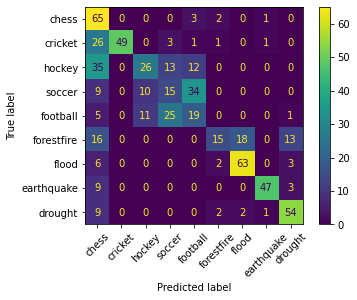

In [54]:
NBMulti = GaussianNB()
NBMulti.fit(trainDataK500, train_leaf_labels)

NBMultiPred = NBMulti.predict(testDataK500)
print("Scores for Gaussian Naive Bayes Classifier")
print('accuracy:', accuracy_score(test_leaf_labels, NBMultiPred))
print('recall:', recall_score(test_leaf_labels, NBMultiPred, average='macro'))
print('precision:', precision_score(test_leaf_labels, NBMultiPred, average='macro'))
print('f1_score:', f1_score(test_leaf_labels, NBMultiPred, average='macro'))

print("Confusion Matrix for Gaussian Naive Bayes Classifier")
plot_confusion_matrix(NBMulti, testDataK500, test_leaf_labels, display_labels=labels, xticks_rotation=45)
plt.show()

#### One vs All SVM 

Scores for SVM Classifier with ONE VS ALL method
accuracy: 0.8095238095238095
recall: 0.8000916018624958
precision: 0.8031211132717664
f1_score: 0.80126226587111
Confusion Matrix for ONE VS ALL SVM Classifier


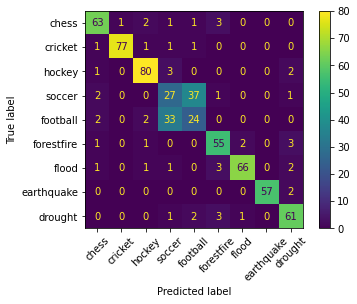

In [55]:
SVMMulti = svm.SVC(kernel='linear') 
SVMMulti = OneVsRestClassifier(SVMMulti).fit(trainDataK500, train_leaf_labels)

SVMMultiPred = SVMMulti.predict(testDataK500)

print("Scores for SVM Classifier with ONE VS ALL method")
print('accuracy:', accuracy_score(test_leaf_labels, SVMMultiPred))
print('recall:', recall_score(test_leaf_labels, SVMMultiPred, average='macro'))
print('precision:', precision_score(test_leaf_labels, SVMMultiPred, average='macro'))
print('f1_score:', f1_score(test_leaf_labels, SVMMultiPred, average='macro'))

print("Confusion Matrix for ONE VS ALL SVM Classifier")
plot_confusion_matrix(SVMMulti, testDataK500, test_leaf_labels, display_labels=labels, xticks_rotation=45)
plt.show()

Scores for SVM Classifier with ONE VS ALL method (With Weight Balancing)
accuracy: 0.7984126984126985
recall: 0.7904357086036167
precision: 0.791071066194889
f1_score: 0.78846172776565
Confusion Matrix for ONE VS ALL SVM Classifier(with Weight Balancing)


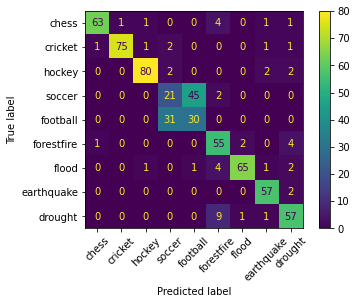

In [56]:
SVMMultiWB = svm.SVC(kernel='linear', class_weight='balanced') 
SVMMultiWB = OneVsRestClassifier(SVMMultiWB).fit(trainDataK500, train_leaf_labels)

SVMMultiWBPred = SVMMultiWB.predict(testDataK500)
print("Scores for SVM Classifier with ONE VS ALL method (With Weight Balancing)")
print('accuracy:', accuracy_score(test_leaf_labels, SVMMultiWBPred))
print('recall:', recall_score(test_leaf_labels, SVMMultiWBPred, average='macro'))
print('precision:', precision_score(test_leaf_labels, SVMMultiWBPred, average='macro'))
print('f1_score:', f1_score(test_leaf_labels, SVMMultiWBPred, average='macro'))

print("Confusion Matrix for ONE VS ALL SVM Classifier(with Weight Balancing)")
plot_confusion_matrix(SVMMultiWB, testDataK500, test_leaf_labels, display_labels=labels, xticks_rotation=45)
plt.show()

#### One vs One SVM

Scores for SVM Classifier with ONE VS ONE method
accuracy: 0.8
recall: 0.7918100332537711
precision: 0.8023690502733226
f1_score: 0.7927855788991267

---------Confusion Matrix for ONE VS ONE SVM Classifier-------


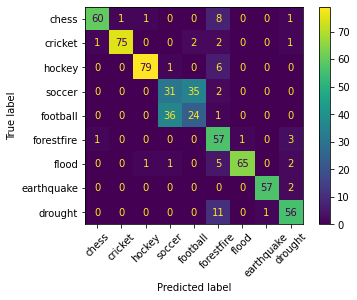

In [57]:
SVMMultiOvo = svm.SVC(kernel='linear') 
SVMMultiOvo = OneVsOneClassifier(SVMMultiOvo).fit(trainDataK500, train_leaf_labels)

SVMMultiPredOvo = SVMMultiOvo.predict(testDataK500)
print("Scores for SVM Classifier with ONE VS ONE method")
print('accuracy:', accuracy_score(test_leaf_labels, SVMMultiPredOvo))
print('recall:', recall_score(test_leaf_labels, SVMMultiPredOvo, average='macro'))
print('precision:', precision_score(test_leaf_labels, SVMMultiPredOvo, average='macro'))
print('f1_score:', f1_score(test_leaf_labels, SVMMultiPredOvo, average='macro'))


print("\n---------Confusion Matrix for ONE VS ONE SVM Classifier-------")
plot_confusion_matrix(SVMMultiOvo, testDataK500, test_leaf_labels, display_labels=labels, xticks_rotation=45)
plt.show()

In [58]:
# Merging football and soccer together 
# Merging forestfire and drought together

train_leaf_labels = train['leaf_label']
test_leaf_labels = test['leaf_label']

labels_NB = ['chess', 'cricket', 'hockey', 'football/soccer', 'fire/drought', 'flood', 'earthquake']

train_leaf_labels_NB = train_leaf_labels.replace(to_replace=['football', 'soccer', '%22forest%20fire%22', 'drought'], value=['football/soccer', 'football/soccer', 'fire/drought', 'fire/drought'], inplace=False)
test_leaf_labels_NB =  test_leaf_labels.replace(to_replace=['football', 'soccer', '%22forest%20fire%22', 'drought'], value=['football/soccer', 'football/soccer', 'fire/drought', 'fire/drought'], inplace=False)
train_leaf_labels_NB = train_leaf_labels_NB.replace(to_replace=['chess', 'cricket', 'hockey', 'football/soccer', 'fire/drought', 'flood', 'earthquake'], value=[0, 1, 2, 3, 4, 5, 6])

test_leaf_labels_NB = test_leaf_labels_NB.replace(to_replace  =['chess', 'cricket', 'hockey', 'football/soccer', 'fire/drought', 'flood', 'earthquake'], value=[0, 1, 2, 3, 4, 5, 6])

Scores for Gaussian NB Over merged data
accuracy: 0.6301587301587301
recall: 0.6600801711016541
precision: 0.7121884964673714
f1_score: 0.6380208524662276
Confusion Matrix for Gaussian NB Over merged data


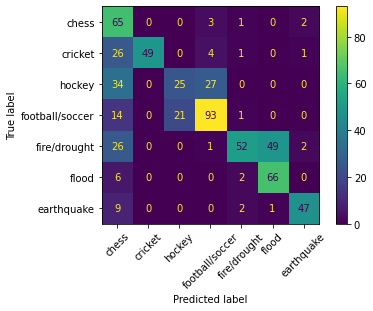

In [59]:
NBMultiMerged = GaussianNB()
NBMultiMerged.fit(trainDataK500, train_leaf_labels_NB)

NBMultiMergedPred = NBMultiMerged.predict(testDataK500)

print("Scores for Gaussian NB Over merged data")
print('accuracy:', accuracy_score(test_leaf_labels_NB, NBMultiMergedPred))
print('recall:', recall_score(test_leaf_labels_NB, NBMultiMergedPred, average='macro'))
print('precision:', precision_score(test_leaf_labels_NB, NBMultiMergedPred, average='macro'))
print('f1_score:', f1_score(test_leaf_labels_NB, NBMultiMergedPred, average='macro'))

print("Confusion Matrix for Gaussian NB Over merged data")
plot_confusion_matrix(NBMultiMerged, testDataK500, test_leaf_labels_NB, display_labels=labels_NB, xticks_rotation=45)
plt.show()

### Q9

The Confusion Matrix are plotted above.

In general, One vs Rest suffers from a class imbalance problem because, when training One vs Rest, one of the n classes is viewed as a positive and all of the other n-1 class as a negative. As a result, the dataset with more samples is dominated by negatives. Weight balancing can be used to address this class imbalance by giving minority class data samples higher weights (C values) such that their misclassification is more severely penalized and majority class data samples lower C values.

    Scores for Gaussian Naive Bayes Classifier
    accuracy: 0.5603174603174603
    recall: 0.5598705675166241
    precision: 0.618678457588529
    f1_score: 0.5532927099680587

    Scores for SVM Classifier with ONE VS ALL method
    accuracy: 0.8111111111111111
    recall: 0.8042005730070291
    precision: 0.7961123952113596
    f1_score: 0.7870421197547192
    
    Scores for SVM Classifier with ONE VS ALL method (With Weight Balancing)
    accuracy: 0.7984126984126985
    recall: 0.7843264354843946
    precision: 0.7855983152729478
    f1_score: 0.7827419853065853

    Scores for SVM Classifier with ONE VS ONE method
    accuracy: 0.8
    recall: 0.7933719771331711
    precision: 0.7988380228450765
    f1_score: 0.7803508665265156

Gaussian Naive Bayes performs bad compared to SVM.

SVM perform good on all classes as we can see there are not much False Positives or False negatives in any specific sub class as such as seen in the confusion matrices of all SVM's scores and confusion matrices above.

But Gaussian Naive Bayes performs bad and this is evident from its confusion matrix.

It's predicting soccer as football in nearly 8 of the test samples. Also there are a lot of misclassifications on class forestfire where most of the forestfire is predicted as drought.

This can somewhat be improved by merging football and soccer in a single class as football/soccer and forestfire and drought can be merged together as fire/drought.

For SVM the results are quite nice, there are no such heavy misclassifications and there is not need to merge any two subclasses together and do ONE VS ALL and ONE VS ONE Strategy as such.

But this the above observed trend for Gaussian Naive Bayes is implemented and results are as follows:
Scores for Gaussian NB Over merged data

    accuracy: 0.6301587301587301
    recall: 0.6600801711016541
    precision: 0.7121884964673714
    f1_score: 0.6380208524662276

** The confusion matrix for Gaussian NB Over merged data is plotted above. Clearly we can see that there is a good resolution among sports subclasses but the climate related articles are not well classified by Gaussian NB.



### Word Embedding

In [60]:
#  Loading GLoVE embeddings.
embeddings_dict = {}
dimension_of_glove = 300
with open("./glove.6B.300d.txt", 'r') as f:
    for line in f:
        values = line.split()
        word = values[0]
        vector = np.asarray(values[1:], "float32")
        embeddings_dict[word] = vector


In [61]:
def preprocessingGlove(sample):
    sample = clean(sample)
    sample = sample.split('.')
    sample = [removeStopwords(nltk.word_tokenize(sentence), stopWords) for sentence in sample]
    sample = [lemmatize(sentence) for sentence in sample]
    sample = " ".join(sample)
    return sample

def removeStopwords(words, stopWords):
    return " ".join([word for word in words if word not in stopWords])

def getDocEmbeddings(doc, embeddings_dict=embeddings_dict):
    embedding_size = len(embeddings_dict['the'])
    words = nltk.word_tokenize(preprocessingGlove(doc))
    count = len(words)
    vector = np.zeros(embedding_size)
    
    for word in words:
        if word in embeddings_dict:
            vector = vector + np.array(embeddings_dict[word])
    
    return (vector/np.linalg.norm(vector, 2))

# Assumes climate as 1.
def getTrainTestEmbeddings(train, test, embeddings_dict=embeddings_dict):
    x_train = np.array([getDocEmbeddings(doc, embeddings_dict) for doc in train['full_text']])
    y_train = (train['root_label'] == 'climate').astype('int')

    x_test = np.array([getDocEmbeddings(doc, embeddings_dict) for doc in test['full_text']])
    y_test = (test['root_label'] == 'climate').astype('int')
    return x_train, y_train, x_test, y_test

In [62]:
x_train_glove, y_train_glove, x_test_glove, y_test_glove = getTrainTestEmbeddings(train, test, embeddings_dict)

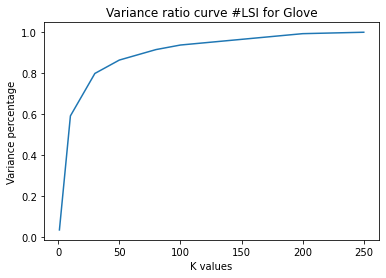

In [63]:
k_values_glove = [1, 10, 30, 50, 80, 100, 200, 250]
variance_ratio_glove = []
reconstructionErrorsGlove = []

for i in range(0, len(k_values_glove)):
    SVD = getSVD(k_values_glove[i], x_train_glove)
    variance_ratio_glove.append(SVD.explained_variance_ratio_.sum())
    transformed = SVD.transform(x_train_glove)
    reconstruct = SVD.inverse_transform(transformed)
    reconstructionErrorsGlove.append(np.linalg.norm((x_train_glove - reconstruct), 'fro') ** 2)
    
plt.plot(k_values_glove, variance_ratio_glove)
plt.xlabel("K values")
plt.ylabel("Variance percentage")
plt.title("Variance ratio curve #LSI for Glove")
plt.show()

### Q10
a). The ratio of co-occurence probabilities is used to train GLoVE embeddings as it provides a more accurate picture of how closely connected a given word is to the other two baseline words.The concrete relationship between a word's coherence with other words is improved, and it penalizes unrelated words more severely. Additionally, it aids in mapping similar words farther into the dimension space, improving resolution. Comparatively, unconnected contextual terms have values that are near to 1, while linked words receive higher/lower absolute scores.

b). Consider the following two scenarios. - If the corpus contains both of these sentences, "running" will have the same GLoVE embedding. - If there is more than one corpus. One corpus with only the first sentence - "James is running in the park" - and another with only the second sentence - "James is running for the presidency" will give us the same embeddings for the word "running" because the number of words in both corpuses is the same, the relative ordering is the same, and there are no other sentences to get co-occurence probabilities of other words, which can change the co-occurence ratios, and thus there is no change in the space which they occupy in dimension space.

c). The value of ||GLoVE["queen"] - GLoVE["king"] - GLoVE["wife"] + GLoVE["husband"]||2 should be close to zeros.<br>
Also the value ||GLoVE["queen"] - GLoVE["king"]||2 should be almost similar to  ||GLoVE["wife"] - GLoVE["husband"]||2. <br>
The context between words is preserved by the embeddings in the form of vector differences, and the corresponding difference between a king and queen is extremely similar to that between a husband and wife. 

d).It is determined by how the GLoVE is implemented. Assume one is building a GLoVE model on one's own corpus and the entire corpus is lemmatized/stemmed before building it; then, at testing time or for later uses, one needs to lemmatize the words to get the embeddings. If the GLoVE model was not trained on a lemmatized/stemmed corpus, the embeddings can be obtained directly.

### Feature Engineering 

In [64]:
# Evaluating model on all of data with 300 features.

# Using the best SVM and Logistic classifier that we found from GridSearchCV 
bestlogisticGlove = LogisticRegression(C=10.0, max_iter=5000, penalty='l1', random_state=42,
                   solver='liblinear')
bestlogisticGlove.fit(x_train_glove, y_train_glove)
bestlogisticGlovePred = bestlogisticGlove.predict(x_test_glove)

bestSVMGlove = svm.SVC(kernel='linear')
bestSVMGlove.fit(x_train_glove, y_train_glove)
bestSVMGlovePred = bestSVMGlove.predict(x_test_glove)

#### Result on logistic regression

Scores for Best Logistic Classifier: LogisticRegression(C=10.0, max_iter=5000, penalty='l1', random_state=42,
                   solver='liblinear')

Accuracy:  0.9619047619047619

Precision:  0.9621983936558282

Recall Score:  0.9619047619047619

F1 Score:  0.9619625988047041


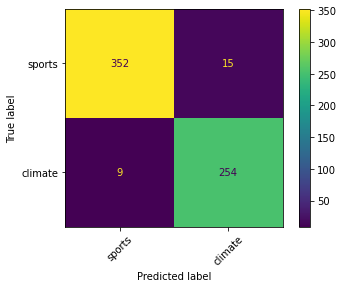

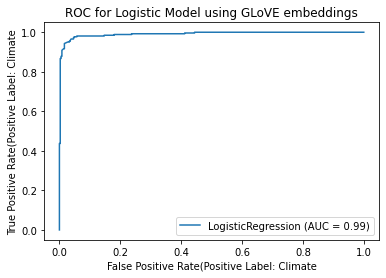

In [67]:
print("Scores for Best Logistic Classifier: {}\n".format(bestlogisticGlove))
print("Accuracy: ", getScores(y_test_glove, bestlogisticGlovePred)['accuracy'])
print("\nPrecision: ", getScores(y_test_glove, bestlogisticGlovePred)['precision'])
print("\nRecall Score: ", getScores(y_test_glove, bestlogisticGlovePred)['recall'])
print("\nF1 Score: ", getScores(y_test_glove, bestlogisticGlovePred)['f1'])

plot_confusion_matrix(bestlogisticGlove, x_test_glove, y_test_glove, display_labels=['sports', 'climate'], xticks_rotation=45)
plt.show()

metrics.plot_roc_curve(bestlogisticGlove, x_test_glove, y_test_glove)
plt.title("ROC for Logistic Model using GLoVE embeddings")
plt.xlabel("False Positive Rate(Positive Label: Climate")
plt.ylabel("True Positive Rate(Positive Label: Climate")
plt.show()

#### Result on Svm



Scores for Best SVM Classifier: SVC(kernel='linear') 

Accuracy:  0.9555555555555556

Precision:  0.9560452763302006

Recall Score:  0.9555555555555556

F1 Score:  0.9556435997702597


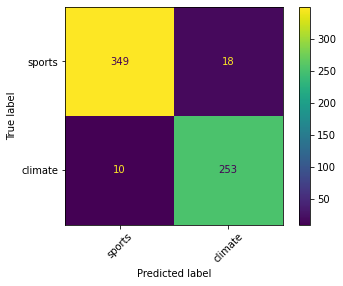

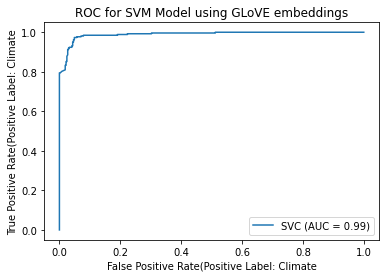

In [68]:
print("\n\nScores for Best SVM Classifier: {} \n".format(bestSVMGlove))
print("Accuracy: ", getScores(y_test_glove, bestSVMGlovePred)['accuracy'])
print("\nPrecision: ", getScores(y_test_glove, bestSVMGlovePred)['precision'])
print("\nRecall Score: ", getScores(y_test_glove, bestSVMGlovePred)['recall'])
print("\nF1 Score: ", getScores(y_test_glove, bestSVMGlovePred)['f1'])

plot_confusion_matrix(bestSVMGlove, x_test_glove, y_test_glove, display_labels=['sports', 'climate'], xticks_rotation=45)
plt.show()

metrics.plot_roc_curve(bestSVMGlove, x_test_glove, y_test_glove)
plt.title("ROC for SVM Model using GLoVE embeddings")
plt.xlabel("False Positive Rate(Positive Label: Climate")
plt.ylabel("True Positive Rate(Positive Label: Climate")
plt.show()

#### GLoVE dim = 200

In [86]:
glove_dim = 200

SVD = getSVD(glove_dim, x_train_glove)
x_train_transGlove = SVD.transform(x_train_glove)
x_test_transGlove = SVD.transform(x_test_glove)

# Logistic classifier on LSI reduced GLoVE features
bestlogisticGlove2 = LogisticRegression(C=10.0, max_iter=5000, penalty='l1', random_state=42,
                   solver='liblinear')
bestlogisticGlove2.fit(x_train_transGlove, y_train_glove)
bestlogisticGlovePred2 = bestlogisticGlove2.predict(x_test_transGlove)

# SVM classifier on LSI reduced GLoVE features
bestSVMGlove2 = svm.SVC(kernel='linear')
bestSVMGlove2.fit(x_train_transGlove, y_train_glove)
bestSVMGlovePred2 = bestSVMGlove2.predict(x_test_transGlove)

Scores for Best Logistic Classifier on 50 LSI reduced embeddings: LogisticRegression(C=10.0, max_iter=5000, penalty='l1', random_state=42,
                   solver='liblinear')

Accuracy:  0.9619047619047619

Precision:  0.9621983936558282

Recall Score:  0.9619047619047619

F1 Score:  0.9619625988047041


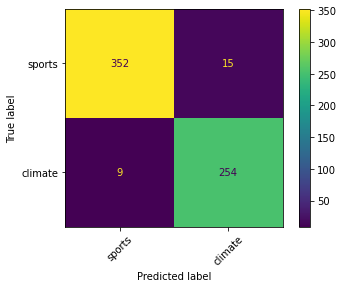

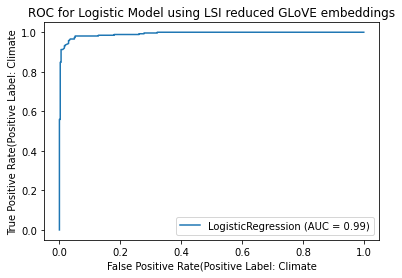

In [87]:
print("Scores for Best Logistic Classifier on 50 LSI reduced embeddings: {}\n".format(bestlogisticGlove2))
print("Accuracy: ", getScores(y_test_glove, bestlogisticGlovePred2)['accuracy'])
print("\nPrecision: ", getScores(y_test_glove, bestlogisticGlovePred2)['precision'])
print("\nRecall Score: ", getScores(y_test_glove, bestlogisticGlovePred2)['recall'])
print("\nF1 Score: ", getScores(y_test_glove, bestlogisticGlovePred2)['f1'])

plot_confusion_matrix(bestlogisticGlove2, x_test_transGlove, y_test_glove, display_labels=['sports', 'climate'], xticks_rotation=45)
plt.show()

metrics.plot_roc_curve(bestlogisticGlove2, x_test_transGlove, y_test_glove)
plt.title("ROC for Logistic Model using LSI reduced GLoVE embeddings")
plt.xlabel("False Positive Rate(Positive Label: Climate")
plt.ylabel("True Positive Rate(Positive Label: Climate")
plt.show()



Scores for Best SVM Classifier on 50 LSI reduced embeddings: SVC(kernel='linear') 

Accuracy:  0.9555555555555556

Precision:  0.9560452763302006

Recall Score:  0.9555555555555556

F1 Score:  0.9556435997702597


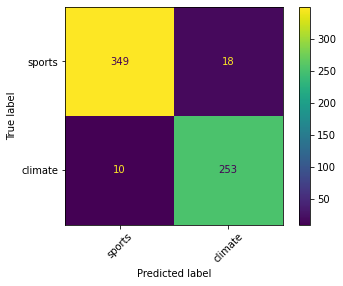

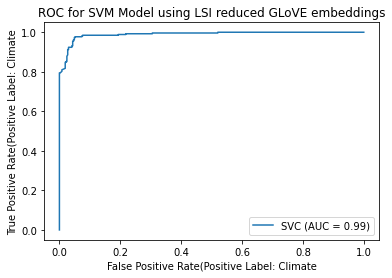

In [81]:
print("\n\nScores for Best SVM Classifier on 50 LSI reduced embeddings: {} \n".format(bestSVMGlove2))
print("Accuracy: ", getScores(y_test_glove, bestSVMGlovePred2)['accuracy'])
print("\nPrecision: ", getScores(y_test_glove, bestSVMGlovePred2)['precision'])
print("\nRecall Score: ", getScores(y_test_glove, bestSVMGlovePred2)['recall'])
print("\nF1 Score: ", getScores(y_test_glove, bestSVMGlovePred2)['f1'])

plot_confusion_matrix(bestSVMGlove2, x_test_transGlove, y_test_glove, display_labels=['sports', 'climate'], xticks_rotation=45)
plt.show()

metrics.plot_roc_curve(bestSVMGlove2, x_test_transGlove, y_test_glove)
plt.title("ROC for SVM Model using LSI reduced GLoVE embeddings")
plt.xlabel("False Positive Rate(Positive Label: Climate")
plt.ylabel("True Positive Rate(Positive Label: Climate")
plt.show()

### Q11)

a). Feature Engineer steps Involved 
    
    --> Preprocessing the raw text which involved removing HTML text, removing punctuation, removing number, stripping extra space, removing stop words using nltk library.
    --> After that, we load a 300-dimensional GLoVE embeddings dictionary, transform each cleaned document's ["full text"] vector representation to a 300-dimensional vector by normalizing it and using the sum of all the document's word embeddings.
    --> Given that embeddings have a size of 300, we would use LSI to reduce it to some K while retaining the greatest variance possible to lessen the effects of the "curse of dimensionality."

b). Following are the results of Best Logistic Classifier and Best SVM model on 300 dim GLoVE feature and 50 dim GLoVE feature obtained after reducing the dimension using LSI 

i) For 300 dim <br>
Scores for Best Logistic Classifier on test data: LogisticRegression(C=10.0, max_iter=5000, penalty='l1', random_state=42, solver='liblinear')

    Accuracy:  0.9619047619047619

    Precision:  0.9621983936558282

    Recall Score:  0.9619047619047619

    F1 Score:  0.9619625988047041

Scores for Best SVM Classifier on test data: SVC(kernel='linear') 

    Accuracy:  0.9555555555555556

    Precision:  0.9560452763302006

    Recall Score:  0.9555555555555556

    F1 Score:  0.9556435997702597    
ii). For 200 dim usiing LSI on top <br>

Scores for Best Logistic Classifier on 200 LSI reduced embeddings: LogisticRegression(C=10.0, max_iter=5000, penalty='l1', random_state=42, solver='liblinear')

    Accuracy: 0.9686746987951808

    Precision: 0.9948717948717949

    Recall Score: 0.941747572815534

    F1 Score: 0.9675810473815462

Scores for Best SVM Classifier on 200 LSI reduced embeddings: SVC(kernel='linear')

    Accuracy: 0.9590361445783132

    Precision: 0.9947643979057592

    Recall Score: 0.9223300970873787

    F1 Score: 0.9571788413098237




### Different dimension of the pre-trained GLoVE embedding

In [102]:
fileNames = ['glove.6B.50d.txt', 'glove.6B.100d.txt', 'glove.6B.200d.txt', 'glove.6B.300d.txt']

accuracies = []
precisions = []
recalls = []
f1s = []

for file in fileNames:
    embeddings_dict = {}
    fpath = "./{}".format(file)
    with open(fpath, 'r') as f:
        for line in f:
            values = line.split()
            word = values[0]
            vector = np.asarray(values[1:], "float32")
            embeddings_dict[word] = vector
            
    x_tr_glove, y_tr_glove, x_te_glove, y_te_glove = getTrainTestEmbeddings(train, test, embeddings_dict)
    
    logModel = LogisticRegression(C=10.0, max_iter=5000, penalty='l1', random_state=42,
                   solver='liblinear')
    logModel.fit(x_tr_glove, y_tr_glove)
    logModelPreds = logModel.predict(x_te_glove)
    
    logScores = getScores(y_te_glove, logModelPreds)
    accuracies.append(logScores['accuracy'])
    precisions.append(logScores['precision'])
    recalls.append(logScores['recall'])
    f1s.append(logScores['f1'])

Text(0.5, 1.0, 'Performance measure of Logistic Classifier on different dimensional GLoVE embeddings')

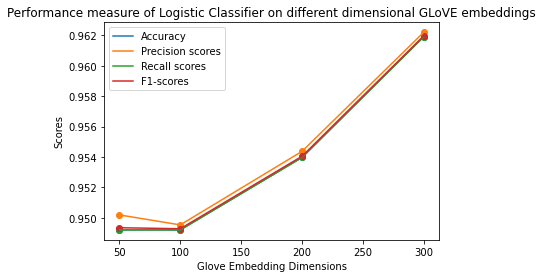

In [103]:
glove_K = [50, 100, 200, 300]

plt.xlabel("Glove Embedding Dimensions")
plt.ylabel("Scores")

plt.scatter(glove_K, accuracies)
plt.plot(glove_K, accuracies)

plt.scatter(glove_K, precisions)
plt.plot(glove_K, precisions)

plt.scatter(glove_K, recalls)
plt.plot(glove_K, recalls)

plt.scatter(glove_K, f1s)
plt.plot(glove_K, f1s)

plt.legend(["Accuracy", "Precision scores", "Recall scores", "F1-scores"], loc="best")
plt.title("Performance measure of Logistic Classifier on different dimensional GLoVE embeddings")


### Q12)

The Graph for Dimension of the pre-trained GLoVE embedding used vs The resulting accuracy of the model can be seen above. <br>
From the graph on can infer that on increasing the dimnesion the resulting accuracy first decreases and then starts increasing linearly. This kind of behavior can be attributed to the fact that data may have become seprable in the higher dimension and therefore we can see the increase in accuracy.

### Visualize GLoVE based Embedding 

In [5]:
import umap.umap_ as umap
import umap.plot

/Users/diplavsrivastava/opt/anaconda3/lib/python3.8/site-packages/umap/plot.py:20: UserWarning: The umap.plot package requires extra plotting libraries to be installed.
    You can install these via pip using

    pip install umap-learn[plot]

    or via conda using

     conda install pandas matplotlib datashader bokeh holoviews colorcet scikit-image
    
  warn(


ImportError: umap.plot requires pandas matplotlib datashader bokeh holoviews scikit-image and colorcet to be installed

In [6]:
import pandas as pd
import datashader as ds
import datashader.transfer_functions as tf
import datashader.bundling as bd
import matplotlib.pyplot as plt
import colorcet
import matplotlib.colors
import matplotlib.cm
import bokeh.plotting as bpl
import bokeh.transform as btr
import holoviews as hv
import holoviews.operation.datashader as hd

ModuleNotFoundError: No module named 'datashader'

In [108]:
mapper = umap.UMAP().fit(x_train_glove)

In [109]:
labs = np.array(['climate' if label == 1 else 'sports' for label in y_train_glove])
umap.plot.points(mapper, labels=labs, color_key_cmap='Paired', background='black')
plt.title("Data visualisation on Root label level using UMAP(300 to 2 dim reduction)")


AttributeError: module 'umap.umap_' has no attribute 'plot'

In [ ]:
mapper = umap.UMAP().fit(x_train_glove)
umap.plot.points(mapper, labels=train['leaf_label'], color_key_cmap='Paired', background='black')
plt.title("Data visualisation on Leaf label level using UMAP(300 to 2 dim reduction)")

In [ ]:
rows = x_train_glove.shape[0]
cols = x_train_glove.shape[1]
randomLabels = np.random.randint(0, 2, rows, dtype=int)
randomVecs = np.random.rand(rows, cols)
for i in range(len(randomVecs)):
    randomVecs[i] = randomVecs[i]/np.linalg.norm(randomVecs[i], 2)
    
mapper = umap.UMAP().fit(randomVecs)
umap.plot.points(mapper, labels=randomLabels, color_key_cmap='Paired', background='black')

plt.title("Plotting random High dimensional data same as Glove with 10 random labels on 2-D plot")

### Q13).

As one can see below it is evident that the two cluster formed are almost seprable which also clear from the accuracy of trained model we are getting.

From the second graph we can see that the cluster formed from the leaf label are not seprable and having overlap with each other. Thus on reducing the dimension GLoVE embedding the accuracy is decreasing.

In the 3rd graph labels are randomly assigned to each of 1657 randomly generated sample of same dimension as GLoVE embedding . Here it can be seen that no clear clusters are there. This implies that some sort of ordering must exist and that all data under consideration by ML must follow some distribution in order to be classified.